In [ ]:
import numpy as np
import pandas as pd
import pickle as pkl
from matplotlib import pyplot as plt
import random
from math import sin, cos, sqrt, atan2, radians
from ease_grid import EASE2_grid
grid_size = 36000
egrid = EASE2_grid(grid_size)
assert egrid.shape == (406, 964)

In [ ]:
# approximate radius of earth in km
def distance(lat1,lat2,lon1,lon2):
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return(distance) #km

In [ ]:
def re_bin_sio2(temp_state):
    for s in range(34,70,2):
        if temp_state<=s:
            return s
        elif temp_state>=70:
            return 70
        else:
            continue

In [ ]:
class IMPAaCS:
    
    impact_test_id = str(round(-87.5726,4))+' '+str(round(33.2921,4))
    
    def __init__(self, egrid, 
                 max_depth_of_impact_melt=330,
                 primitive_initial_state=45,
                 fraction_upper_layer = 2/3,
                 target_SiO2 = 62.58,     # From sudbury
                 upper_SiO2 = 68.71,      # From sudbury
                 n_layers_impact_melt = 2,
                 z_discretized_km = int(2),
                 proportion_melt_from_impact = 1/3,
                 sim_time=0):
        self.egrid = egrid
        self.primitive_initial_state = primitive_initial_state
        self.max_depth_of_impact_melt = max_depth_of_impact_melt
        self.fraction_upper_layer = fraction_upper_layer        # d_upper / Mi (from Sudbury)
        self.fraction_lower_layer = 1-self.fraction_upper_layer # d_lower / Mi (from Sudbury)
        self.n_layers_impact_melt = n_layers_impact_melt
        self.target_SiO2 = target_SiO2 # From sudbury
        self.upper_SiO2 = upper_SiO2  # From sudbury
        self.z_discretized_km = z_discretized_km
        self.proportion_melt_from_impact = proportion_melt_from_impact
        self.average_target = self.primitive_initial_state
        self.average_target_list = [self.primitive_initial_state]
        self.top_layer_at_test_cell = [self.primitive_initial_state]
        self.average_test_target_list = [self.primitive_initial_state]
        self.n_x = self.egrid.londim.shape[0]
        self.n_y = self.egrid.latdim.shape[0]
        self.sim_time=sim_time
        
        self.count_test_hits = 0
        self.grid_cell_state = {}
        self.impacted_grid_cells = []
        self.impactors_at_test_cell = [0]
        self.test_time = [0]
        
        self.state_prep()

    #--------------------------------------------------------------------------------------------------
    def update(self, impact_loc, impactor_diameter, sim_time=0):
        self.sim_time = sim_time
        self.impact_dimensions(impactor_diameter)
        self.find_the_grid(impact_loc)
        self.get_average_target(impactor_diameter)
        self.loop_impact_grid(impactor_diameter)
        
    #--------------------------------------------------------------------------------------------------
    #---- THIS IS THE MAIN CODE -------------------- THIS IS THE MAIN CODE ----------------------------
    #--------------------------------------------------------------------------------------------------
    def state_dynamics(self, impactor_diameter, grid_cell_id):
        """
        This is the critical component of this model
        This function will change the chemical makeup of each grid cell
            according to the chemical theory put forward by Faltys-Wielicki [2021]
        """
        
        #####      DYNAMIC FACTORS       ############################
        depth_of_impact_melt = impactor_diameter * self.proportion_melt_from_impact # D/3

        #Vertical discretization.
        melt_layers = int(depth_of_impact_melt / self.z_discretized_km)

        lower_layer  = range(int(round(self.fraction_upper_layer * melt_layers,2)), melt_layers)
        upper_layer  = range(0, int(round(self.fraction_upper_layer * melt_layers,2)))

        fracionated_melt = depth_of_impact_melt * self.fraction_upper_layer #Units: km

        fractionation_factor = 1 - (self.target_SiO2 / self.upper_SiO2)

        #####      DO THE DYANMICS       #############################
        # Set lower layer to primitive initial state.  
        for i in lower_layer:
            self.grid_cell_state[grid_cell_id][i] = self.primitive_initial_state

        # Impact melt portion  (Upper)
        for i in upper_layer:
            self.grid_cell_state[grid_cell_id][i] = self.average_target / (1 - fractionation_factor)

        # Weighted average of upper    
        wt_sio2_upper = self.grid_cell_state[grid_cell_id][0]

        # Lower of impact melt portion
        for i in lower_layer:
            numerator = self.average_target-(self.fraction_upper_layer * wt_sio2_upper)
            self.grid_cell_state[grid_cell_id][i] = numerator / self.fraction_lower_layer

        for i in range(melt_layers):
            self.grid_cell_state[grid_cell_id][i] = np.round(self.grid_cell_state[grid_cell_id][i],1)
    
    #--------------------------------------------------------------------------------------------------    
    def state_prep(self):
        total_layers = int(self.max_depth_of_impact_melt / self.z_discretized_km)
        for ilon in self.egrid.londim:
            for ilat in self.egrid.latdim:
                grid_cell_id = str(round(ilon,4))+' '+str(round(ilat,4))
                self.grid_cell_state[grid_cell_id] = np.ones(total_layers) * self.primitive_initial_state
    
    #--------------------------------------------------------------------------------------------------    
    def get_average_target(self, impactor_diameter):
        average_target = 0
        for grid_cell in self.impacted_grid_cells:
            grid_cell_id = str(round(grid_cell[0],4))+' '+str(round(grid_cell[1],4))
            ### If the grid cell has not been hit yet, it is the initial primitive value
            if grid_cell_id in self.grid_cell_state.keys():
                average_target += np.sum(self.grid_cell_state[grid_cell_id][:self.z_layers])
            else:
                average_target += self.primitive_initial_state * self.z_layers
        self.average_target = average_target/(len(self.impacted_grid_cells) * self.z_layers)
        
    #--------------------------------------------------------------------------------------------------    
    def find_the_grid(self, impact_loc):
        self.impacted_grid_cells = [] # first reset the impacted grid cells, then fill them up
        Dmin=10000000
        for ilon in self.egrid.londim:
            for ilat in self.egrid.latdim:
                D = distance(impact_loc[0],ilat,impact_loc[1],ilon)
                if D < Dmin:
                    Dmin = D
                if D <= self.crator_radius:
                    self.impacted_grid_cells.append([ilon, ilat])
        if len(self.impacted_grid_cells) < 1:
            print("Warning. There are no grids impacted!")
            print('Dmin', Dmin, 'crator radius', self.crator_radius, 'impact location', impact_loc)
            for ilon in self.egrid.londim:
                for ilat in self.egrid.latdim:
                    D = distance(impact_loc[0],ilat,impact_loc[1],ilon)
                    if D == Dmin:
                        self.impacted_grid_cells.append([ilon, ilat])
                        print('impacting grid cell', [ilon, ilat])
    #--------------------------------------------------------------------------------------------------    
    def loop_impact_grid(self, impactor_diameter):
        for grid_cell in self.impacted_grid_cells:
            grid_cell_id = str(round(grid_cell[0],4))+' '+str(round(grid_cell[1],4))

            ################      DO THE DYANMICS       #############################
            self.state_dynamics(impactor_diameter, grid_cell_id)

            self.test_one_grid_cell(grid_cell_id, impactor_diameter)
    #--------------------------------------------------------------------------------------------------    
    def impact_dimensions(self, impactor_diameter):
            # The impact crator is 10*Diameter, so the radius is half that
            self.crator_diameter = 10*impactor_diameter
            self.crator_radius = self.crator_diameter/2
            self.z_layers = int(np.ceil(impactor_diameter / self.z_discretized_km))

    #--------------------------------------------------------------------------------------------------    
    def test_one_grid_cell(self, grid_cell_id, impactor_diameter):
        ##### Testing one cell:
        if grid_cell_id == self.impact_test_id:
            self.count_test_hits+=1
            self.test_time.append(self.sim_time)
            self.impactors_at_test_cell.append(impactor_diameter)
            self.average_test_target_list.append(self.average_target)
            self.top_layer_at_test_cell.append(self.grid_cell_state[self.impact_test_id][0])
    
    #--------------------------------------------------------------------------------------------------
    def plot_map(self, save_figure=False, plot_figure=False,):
        if not plot_figure and not save_figure:
            print('not plotting figure')
            return
        z = np.zeros([self.n_x, self.n_y])
        for i, ilon in enumerate(self.egrid.londim):
            for j, ilat in enumerate(self.egrid.latdim):
                grid_cell = str(round(ilon,4))+' '+str(round(ilat,4))
                temp_state = np.mean(self.grid_cell_state[grid_cell][0:2])
                temp_state = re_bin_sio2(temp_state)
                z[i, j] = temp_state
        X, Y = np.meshgrid(self.egrid.londim, self.egrid.latdim)
        fig, ax1 = plt.subplots(figsize=(12, 5))
        
        #ax1.contourf(X, Y, np.transpose(z))
        
        cs = ax1.contourf(X, Y, np.transpose(z), vmin=34, vmax=70) 
        cbar = fig.colorbar(cs, ticks=range(34,70,2))
        
        ax1.set_title('top 2-meter sio2 at time {}myr.png'.format(int(self.sim_time/1000000)))
        ax1.set_xlabel('longitude')
        ax1.set_ylabel('latitude')
        ax1.set_xlim([-90, 90])
        ax1.set_ylim([-45, 45])
        if save_figure:
            plt.savefig('./figs/maps/sio2_map_at_time_{}myr.png'.format(int(self.sim_time/1000000)), 
                    bbox_inches='tight')
        if plot_figure:
            plt.show()
        plt.close()

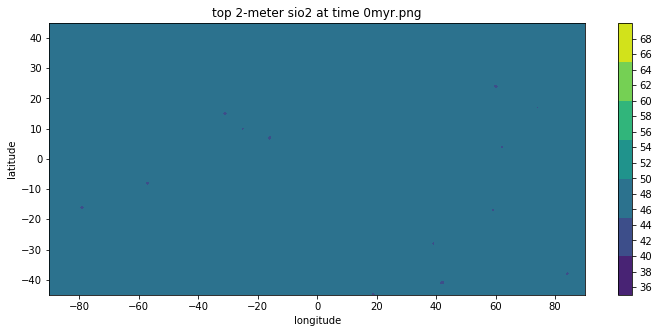

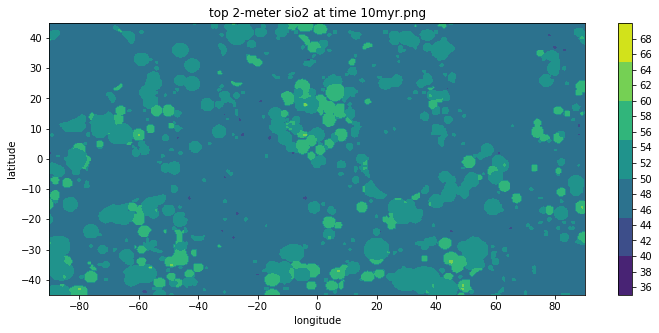

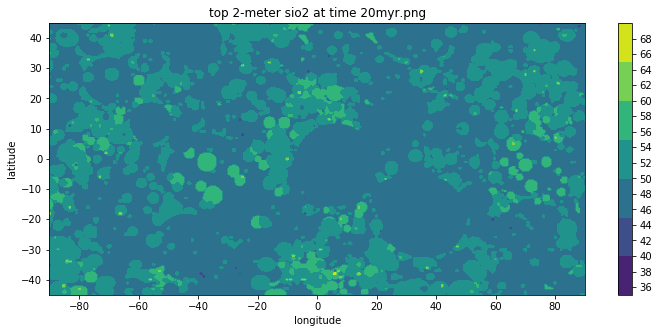

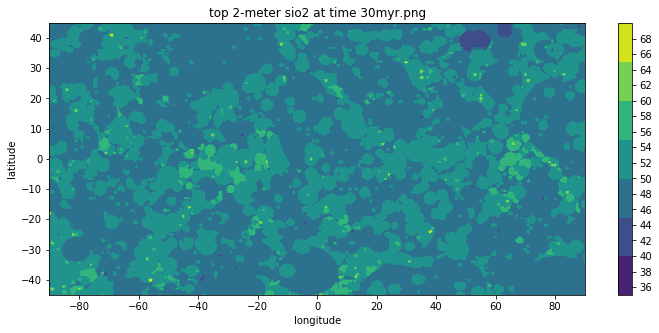

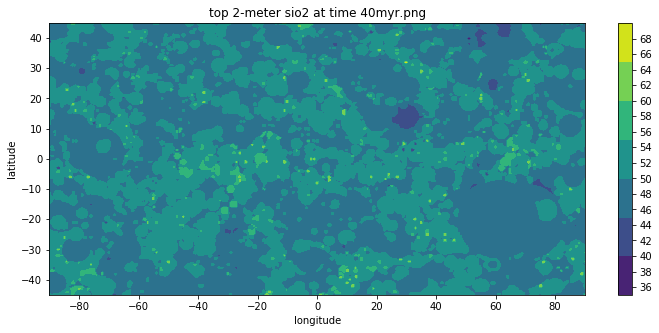

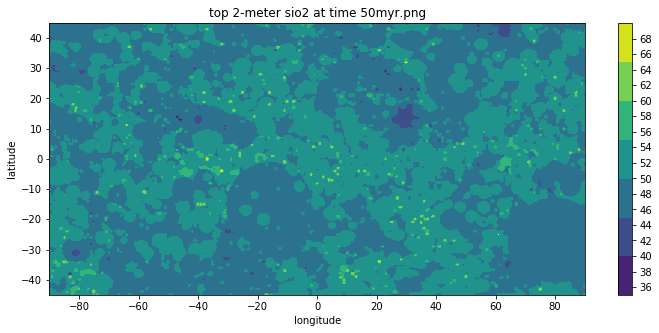

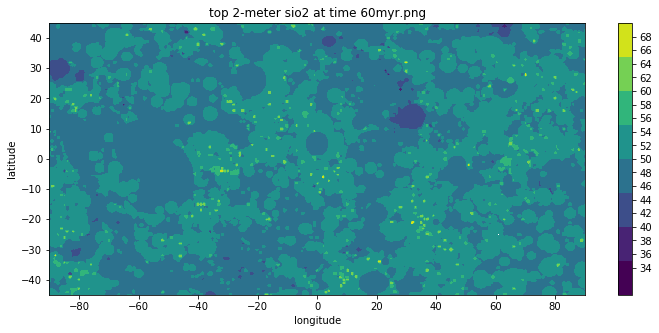

In [27]:
I = IMPAaCS(egrid)
for t in range(0, 70, 10):
    state_file = './impact_states/impacts_E1_t{:d}.pkl'.format(t)
    with open(state_file, 'rb') as fb:
        impact_states = pkl.load(fb)
#    # To force the scale to be consistent
    impact_states[list(impact_states.keys())[0]][:] = 35
    impact_states[list(impact_states.keys())[1]][:] = 70
    I.grid_cell_state = impact_states
    I.sim_time=t*1000000
    I.plot_map(save_figure=False, plot_figure=True)

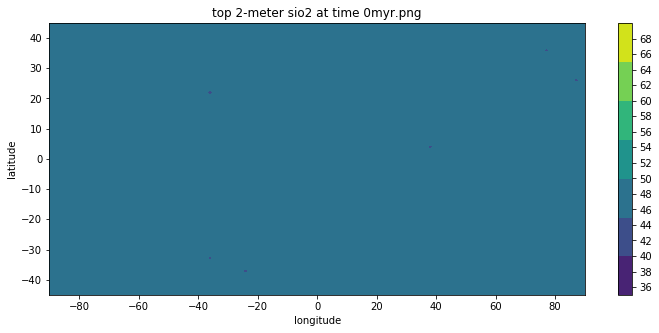

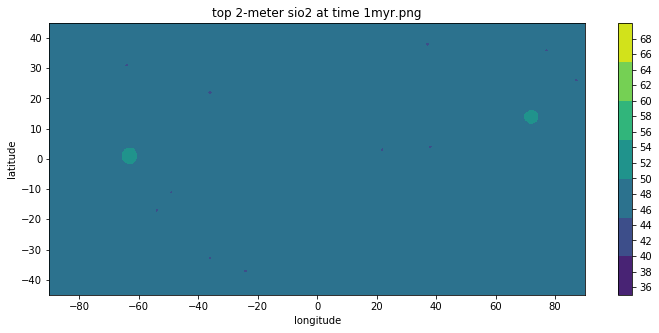

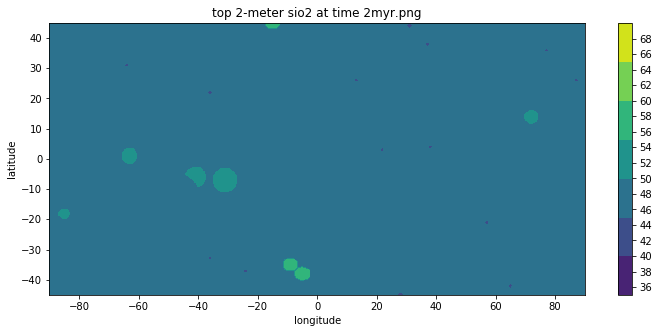

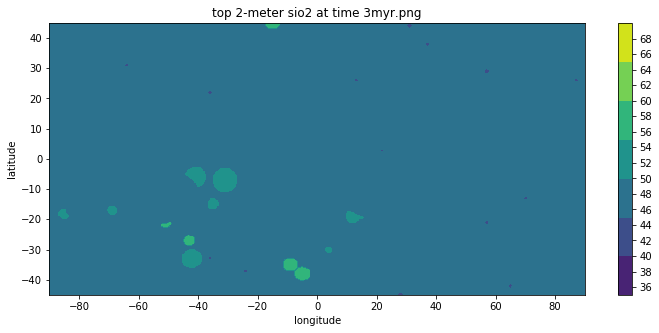

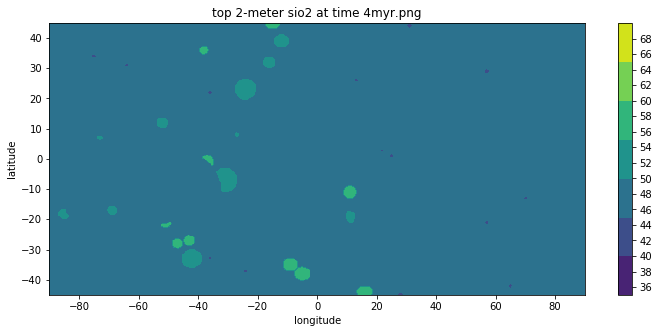

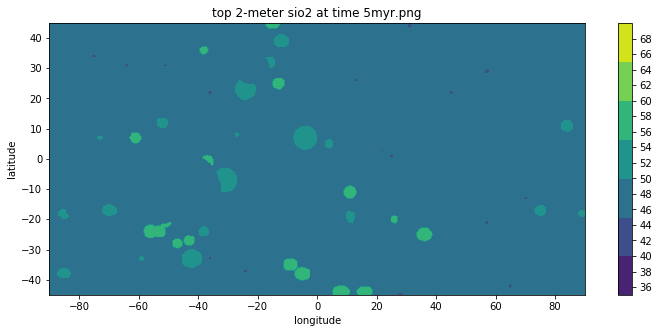

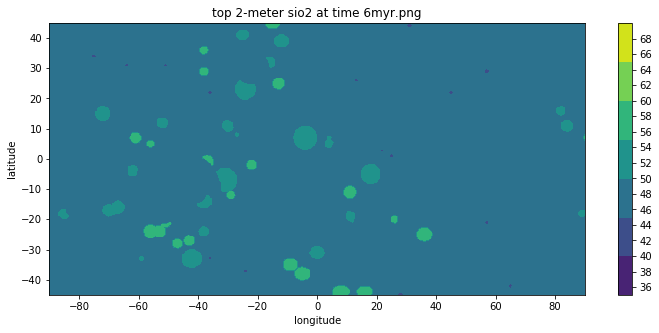

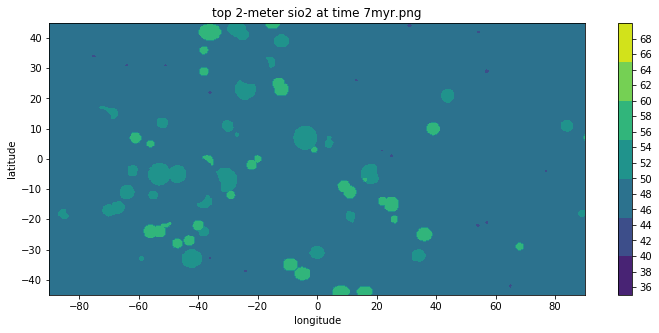

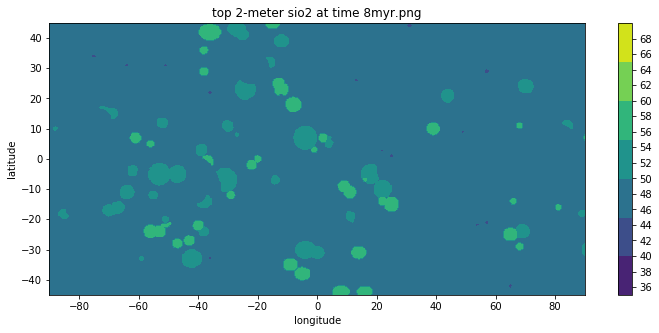

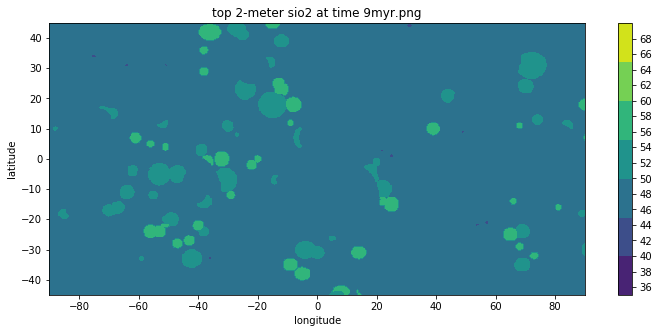

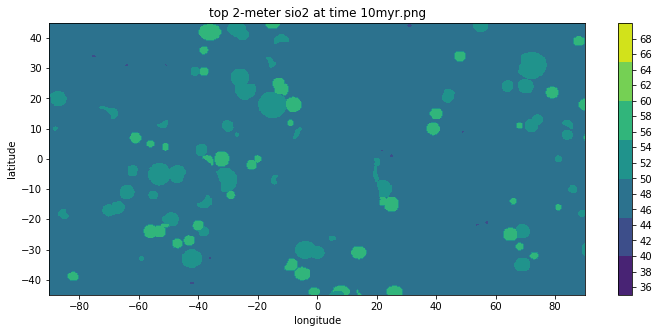

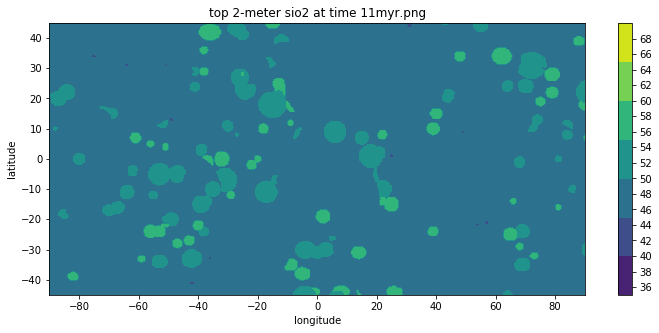

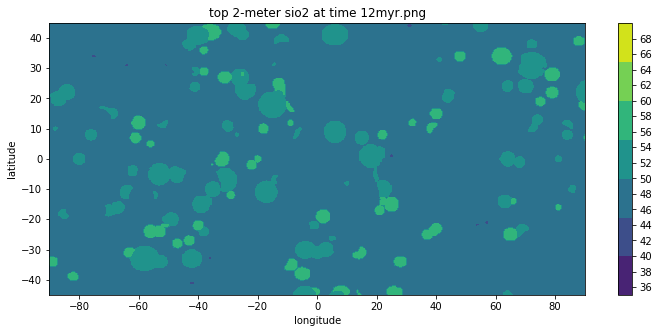

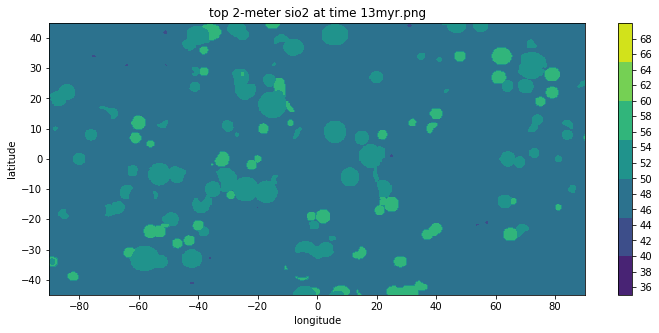

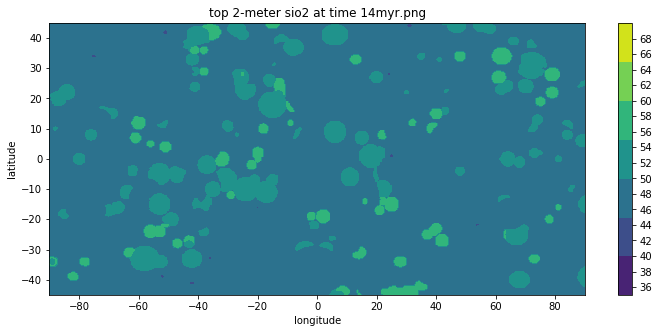

In [25]:
I = IMPAaCS(egrid)
for t in range(15):
    state_file = './impact_states/impacts_10min_45lat_t{:d}.pkl'.format(t)
    with open(state_file, 'rb') as fb:
        impact_states = pkl.load(fb)
#    # To force the scale to be consistent
    impact_states[list(impact_states.keys())[0]][:] = 35
    impact_states[list(impact_states.keys())[1]][:] = 70
    I.grid_cell_state = impact_states
    I.sim_time=t*1000000
    I.plot_map(save_figure=False, plot_figure=True)

./impact_states/E1/impacts_E1_t10.pkl
max 58
mean 49.17
median 50.0
min 42


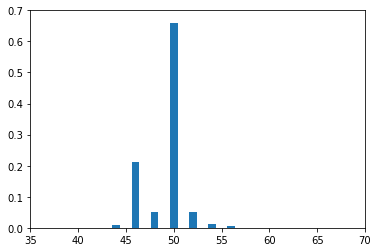

./impact_states/E1/impacts_E1_t20.pkl
max 60
mean 49.75
median 50.0
min 38


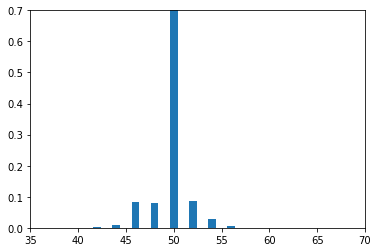

./impact_states/E1/impacts_E1_t30.pkl
max 58
mean 49.97
median 50.0
min 38


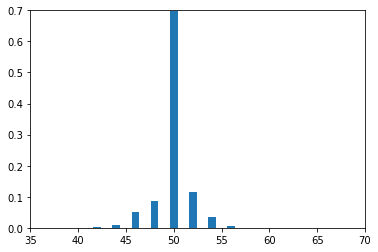

./impact_states/E1/impacts_E1_t40.pkl
max 62
mean 49.97
median 50.0
min 38


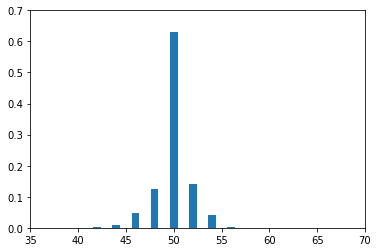

./impact_states/E1/impacts_E1_t50.pkl
max 62
mean 49.8
median 50.0
min 38


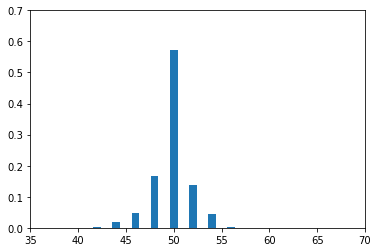

./impact_states/E1/impacts_E1_t60.pkl
max 62
mean 49.63
median 50.0
min 38


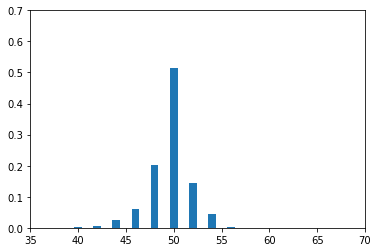

In [22]:
min_value = 100

for t in [10, 20, 30, 40, 50, 60]:
    state_file = './impact_states/E1/impacts_E1_t{:d}.pkl'.format(t)
    print(state_file)
    with open(state_file, 'rb') as fb:
        impact_states = pkl.load(fb)
    total_list = []
    for i in impact_states.keys():
        
        # Don't analyze anything close to polar
        if np.abs(float(i.split(" ")[1])) > 45:
            continue
            
        mean_sio2 = np.mean(impact_states[i][0:5])
        total_list.append(re_bin_sio2(mean_sio2))
        
        if np.min(impact_states[i][:]) < min_value:
            min_value = np.min(impact_states[i][:])
            min_state = i
        
    print('max', np.round(np.max(total_list), 2))
    print('mean', np.round(np.mean(total_list), 2))
    print('median', np.round(np.median(total_list), 2))
    print('min', np.round(np.min(total_list), 2))
    
    bar_data = {}
    for u in np.unique(total_list):
        bar_data[u] = total_list.count(u)/len(total_list)
    
    plt.bar(list(bar_data.keys()), list(bar_data.values()))
    plt.xlim([35,70])
    plt.ylim([0,.7])
    plt.show()
    plt.close()


./impact_states/impacts_10min_45lat_t5.pkl
max 54
mean 48.09
median 50.0
min 42


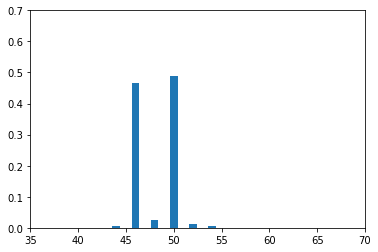

./impact_states/impacts_10min_45lat_t10.pkl
max 56
mean 48.89
median 50.0
min 42


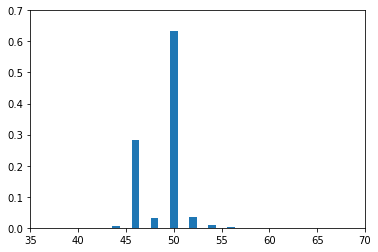

./impact_states/impacts_10min_45lat_t15.pkl
max 56
mean 49.52
median 50.0
min 42


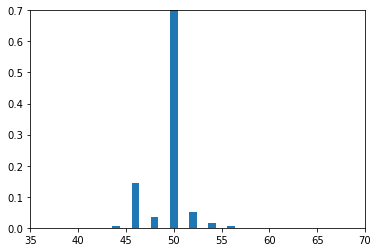

./impact_states/impacts_10min_45lat_t20.pkl
max 56
mean 49.66
median 50.0
min 42


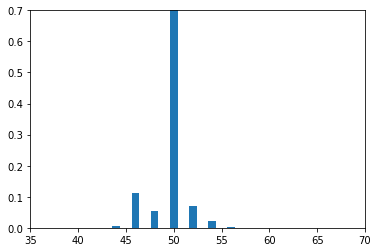

In [26]:
min_value = 100

for t in [5, 10, 15, 20]:
    state_file = './impact_states/impacts_10min_45lat_t{:d}.pkl'.format(t)
    print(state_file)
    with open(state_file, 'rb') as fb:
        impact_states = pkl.load(fb)
    total_list = []
    for i in impact_states.keys():
        
        # Don't analyze anything close to polar
        if np.abs(float(i.split(" ")[1])) > 45:
            continue
            
        mean_sio2 = np.mean(impact_states[i][0:5])
        total_list.append(re_bin_sio2(mean_sio2))
        
        if np.min(impact_states[i][:]) < min_value:
            min_value = np.min(impact_states[i][:])
            min_state = i
        
    print('max', np.round(np.max(total_list), 2))
    print('mean', np.round(np.mean(total_list), 2))
    print('median', np.round(np.median(total_list), 2))
    print('min', np.round(np.min(total_list), 2))
    
    bar_data = {}
    for u in np.unique(total_list):
        bar_data[u] = total_list.count(u)/len(total_list)
    
    plt.bar(list(bar_data.keys()), list(bar_data.values()))
    plt.xlim([35,70])
    plt.ylim([0,.7])
    plt.show()
    plt.close()
